<center>


# **Assignment 1 - Problem 5**

### Question No.1. Vision Dataset: imagenette/160px-v2- Imagenette is a subset of 10 easily classified classes from the Imagenet dataset.

## **DL Group 205**

## **Contributors:**

**1. MADHU KANUKULA (2019AB04116)**

**2. PRASHANT KUMAR (2019AB04158)**

**3. ARKAJYOTI MISRA (2019AB04147)**


</center>

In [36]:
!nvidia-smi

Sun May 23 15:34:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    396MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **1. Import Libraries/Dataset**

In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [38]:
# Downloading the Dataset from Tensorflow Datasets
(ds_train, ds_test), ds_info = tfds.load(
    'imagenette/160px-v2',
    split=['train','validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [39]:
#Backing the test Dataset for plot and validation purpose
ds_val = ds_test

## **2. Data Visualization and augmentation**

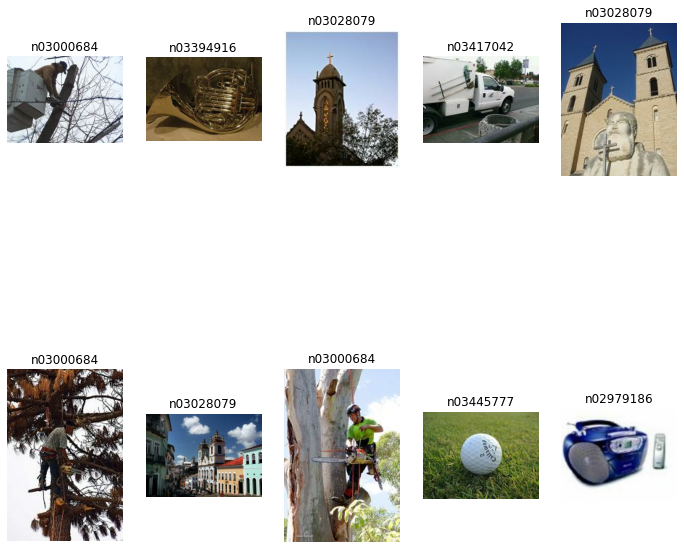

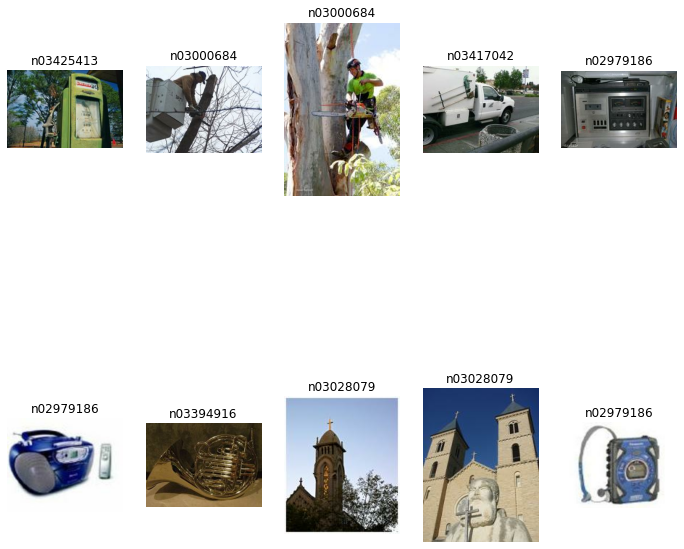

In [40]:
## Plotting at least two samples from each class of the dataset

class_names = ds_info.features['label']
ds_train = ds_train.shuffle(10)
plt.figure(figsize=(12, 12))
i = 0
for images, labels in ds_train.take(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images.numpy().astype("uint8"), )
    plt.title(class_names.names[labels])
    plt.axis("off")
    i+=1

ds_test = ds_test.shuffle(10)
plt.figure(figsize=(12, 12))
i = 0
for images, labels in ds_train.take(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(images.numpy().astype("uint8"))
  plt.title(class_names.names[labels])
  plt.axis("off")
  i+=1

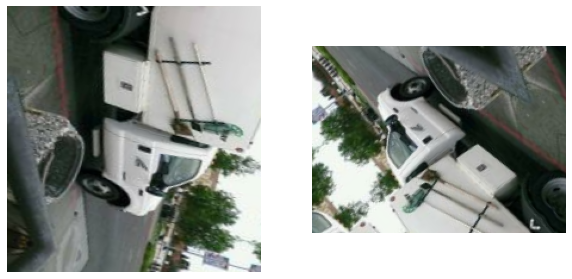

In [41]:
## Applying rotation and height shift augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomHeight(0.5),
  layers.experimental.preprocessing.RandomRotation(.5),
])

image, label = next(iter(ds_train))

# Add the image to a batch
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(2):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(1, 2, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


In [42]:
IMG_SIZE = 32
BATCH_SIZE = 128
EPOCHS = 30

In [43]:
## Normalize function
def _normalize_img(img, label):
    img = tf.image.resize(img,[IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.
    return img, label

In [44]:
## Bring the train and test data in the required format.

ds_train = ds_train.map(_normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(_normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


In [45]:
## Print the shapes of train and test data.

print("Train dataset shape and split count: ", ds_train, ds_info.splits['train'])
print("Test dataset shape and split count: ", ds_test , ds_info.splits['validation'])

Train dataset shape and split count:  <PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)> <tfds.core.SplitInfo num_examples=9469>
Test dataset shape and split count:  <PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)> <tfds.core.SplitInfo num_examples=3925>


## **3. Model Building**

In [46]:
## Sequential model with 3 or more hidden layers, l2 regularization with relu activation, softmax output and dropout at layer2 

model = tf.keras.models.Sequential([  
  tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3, )),
  tf.keras.layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
  tf.keras.layers.Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
  # Tried dropout at different layers with differrent values(like 0.5, 0.3, 0.4), but at layer2 with 0.2 it gave good accuracy.
  tf.keras.layers.Dropout(.2), 
  tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),    
  tf.keras.layers.Dense(10, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 60)                184380    
_________________________________________________________________
dense_5 (Dense)              (None, 120)               7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                6050      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total params: 198,260
Trainable params: 198,260
Non-trainable params: 0
________________________________________________

## **4. Model Compilation**

In [47]:
## Model compilation with SparseCategoricalCrossentropy(categorical_crossentropy) with Adam optimization with default learning rate
"""
Adam optimizer choosen because of 
Adam optimization is a stochastic gradient descent method that is based on
adaptive estimation of first-order and second-order moments. Adam
is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients,
and is well suited for problems that are large in terms of data and/or parameters. 
The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients.
"""
model.compile(
    optimizer=tf.keras.optimizers.Adam(.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## **5. Model Training**

In [48]:
h = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test, shuffle= True, batch_size = BATCH_SIZE,
)

Epoch 1/30
74/74 [==============================] - 4s 20ms/step - loss: 4.3858 - accuracy: 0.1496 - val_loss: 2.9201 - val_accuracy: 0.2757
Epoch 2/30
74/74 [==============================] - 0s 4ms/step - loss: 2.7676 - accuracy: 0.2635 - val_loss: 2.4446 - val_accuracy: 0.2897
Epoch 3/30
74/74 [==============================] - 0s 4ms/step - loss: 2.3813 - accuracy: 0.3046 - val_loss: 2.2689 - val_accuracy: 0.2991
Epoch 4/30
74/74 [==============================] - 0s 5ms/step - loss: 2.2414 - accuracy: 0.3141 - val_loss: 2.2228 - val_accuracy: 0.3047
Epoch 5/30
74/74 [==============================] - 0s 4ms/step - loss: 2.1911 - accuracy: 0.3206 - val_loss: 2.1664 - val_accuracy: 0.3317
Epoch 6/30
74/74 [==============================] - 0s 4ms/step - loss: 2.1357 - accuracy: 0.3381 - val_loss: 2.1472 - val_accuracy: 0.3241
Epoch 7/30
74/74 [==============================] - 0s 4ms/step - loss: 2.1173 - accuracy: 0.3375 - val_loss: 2.1190 - val_accuracy: 0.3205
Epoch 8/30
74/74 [=

## **6. Model Evaluation**

In [49]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.980757474899292
Final training accuracy  0.40996935963630676


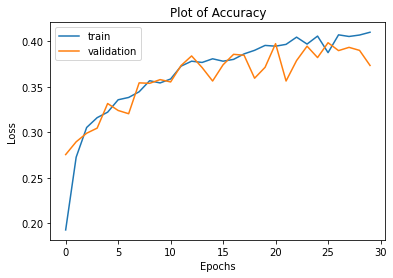

In [50]:
# plot the training  accuracy  

plt.plot(h.history['accuracy'], label='train')
plt.plot(h.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

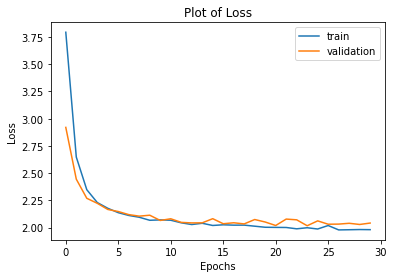

In [51]:
# plot the traininig loss 

plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

In [52]:
# testing the model

testLoss, testAccuracy = model.evaluate(ds_test.take(1000), batch_size=32)

31/31 [==============================] - 0s 2ms/step - loss: 2.0414 - accuracy: 0.3735


In [53]:
print('Testing loss \t', testLoss)
print('Testing accuracy ', testAccuracy)

Testing loss 	 2.041377067565918
Testing accuracy  0.373503178358078


In [54]:
y_pred = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred, axis=1)

In [55]:
true_categories = tf.concat([y for x, y in ds_test], axis=0)


In [56]:
confusion_matrix(predicted_categories, true_categories)

array([[307, 124,  30, 121,  56, 122,  60, 117, 113,  29],
       [  2,  38,   9,  11,   4,  11,   6,   9,   6,   0],
       [  3,  16, 133,  16,   4,   4,  19,  18,   6,   4],
       [  9,  69,  24,  68,   6,  44,  21,  32,  12,  19],
       [ 11,  13,  22,   8, 184,  21,  37,  48,  37,  36],
       [ 18,  48,  33,  77,  62, 145,  17,  69,  25,  13],
       [ 22,  25,  58,  28,  33,  20, 203,  54,  27,  21],
       [  5,  18,   8,  17,   6,  14,   9,  21,   4,   3],
       [  3,  11,  12,   1,   7,   2,   5,  15, 110,   8],
       [  7,  33,  28,  39,  47,  11,  12,  36,  59, 257]])

In [57]:
cl = ds_info.features['label']
print(classification_report(true_categories, predicted_categories, target_names=cl.names))
#as per below F1 -score is good for class n03888257 and worst for class n03425413       

              precision    recall  f1-score   support

   n01440764       0.28      0.79      0.42       387
   n02102040       0.40      0.10      0.15       395
   n02979186       0.60      0.37      0.46       357
   n03000684       0.22      0.18      0.20       386
   n03028079       0.44      0.45      0.45       409
   n03394916       0.29      0.37      0.32       394
   n03417042       0.41      0.52      0.46       389
   n03425413       0.20      0.05      0.08       419
   n03445777       0.63      0.28      0.38       399
   n03888257       0.49      0.66      0.56       390

    accuracy                           0.37      3925
   macro avg       0.40      0.38      0.35      3925
weighted avg       0.39      0.37      0.35      3925



In [58]:
y_test = [y for X, y in ds_test]
X_test = [X for X, y in ds_test]

In [59]:
flat_list = []
for sublist in y_test:
    for item in sublist:
        flat_list.append(item)
y_test_flat = flat_list
y_test_flat = np.uint8(y_test_flat)
y_test_flat

array([9, 2, 6, ..., 8, 6, 5], dtype=uint8)

In [60]:
print(len(y_test_flat))
print(len(y_pred))

3925
3925


In [61]:
print("miss classified label index, predicted_label, actual_label")
for i in range(20):
  if(np.argmax(y_pred[i]) != y_test_flat[i]):
    print(i, np.argmax(y_pred[i]), y_test_flat[i])

miss classified label index, predicted_label, actual_label
3 0 3
4 4 7
6 0 3
7 9 7
9 3 1
10 5 1
11 5 3
12 9 7
14 0 9


In [62]:
print(np.argmax(y_pred[3]))
print(y_test_flat[3])

0
3


In [63]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names.names[predicted_label],
                                100*np.max(predictions_array),
                                class_names.names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

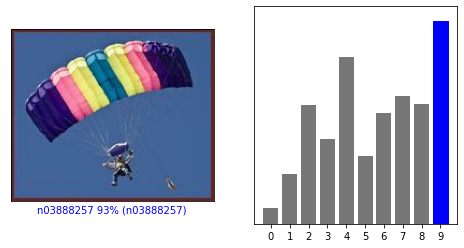

In [64]:
## plot currectly classified

X_test = [X for X, y in ds_val]
i =0
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], y_test_flat, X_test)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  y_test_flat)
plt.show()

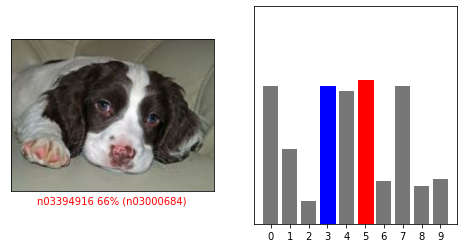

In [79]:
## plot miss classified 
i = 3
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], y_test_flat, X_test)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  y_test_flat)
plt.show()

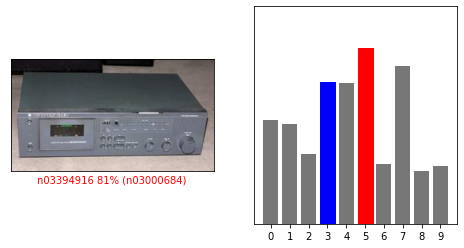

In [66]:
## Plot miss classified
i = 11
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], y_test_flat, X_test)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  y_test_flat)
plt.show()

## **Hyperparameter Tuning**

### **1. Dropout: Change the position and value of dropout layer**

In [67]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3, )),
  tf.keras.layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
  tf.keras.layers.Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),  
  tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),  
  tf.keras.layers.Dropout(.5),  
  tf.keras.layers.Dense(10, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                184380    
_________________________________________________________________
dense_9 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
Total params: 198,260
Trainable params: 198,260
Non-trainable params: 0
________________________________________________

In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [69]:
h1 = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test, shuffle= True,
)

Epoch 1/30
74/74 [==============================] - 1s 6ms/step - loss: 4.5475 - accuracy: 0.1409 - val_loss: 3.1771 - val_accuracy: 0.2099
Epoch 2/30
74/74 [==============================] - 0s 4ms/step - loss: 2.9924 - accuracy: 0.2220 - val_loss: 2.5776 - val_accuracy: 0.2545
Epoch 3/30
74/74 [==============================] - 0s 4ms/step - loss: 2.5229 - accuracy: 0.2584 - val_loss: 2.3877 - val_accuracy: 0.2907
Epoch 4/30
74/74 [==============================] - 0s 4ms/step - loss: 2.3451 - accuracy: 0.2822 - val_loss: 2.2489 - val_accuracy: 0.2879
Epoch 5/30
74/74 [==============================] - 0s 4ms/step - loss: 2.2562 - accuracy: 0.2919 - val_loss: 2.1916 - val_accuracy: 0.3011
Epoch 6/30
74/74 [==============================] - 0s 4ms/step - loss: 2.2159 - accuracy: 0.2924 - val_loss: 2.1758 - val_accuracy: 0.3266
Epoch 7/30
74/74 [==============================] - 0s 4ms/step - loss: 2.1785 - accuracy: 0.3040 - val_loss: 2.1384 - val_accuracy: 0.3175
Epoch 8/30
74/74 [==

Final training loss 	 2.0730135440826416
Final training accuracy  0.33192524313926697


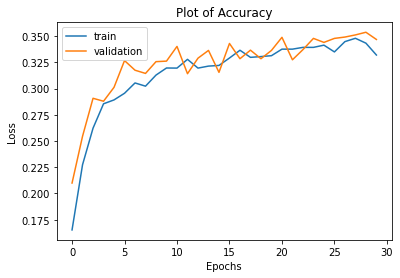

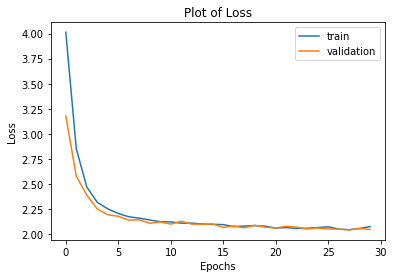

31/31 [==============================] - 0s 2ms/step - loss: 2.0438 - accuracy: 0.3468
Testing loss 	 2.043783187866211
Testing accuracy  0.3467516005039215


In [70]:
print('Final training loss \t', h1.history['loss'][-1])
print('Final training accuracy ', h1.history['accuracy'][-1])

# plot the training  accuracy  

plt.plot(h1.history['accuracy'], label='train')
plt.plot(h1.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

# plot the traininig loss 

plt.plot(h1.history['loss'], label='train')
plt.plot(h1.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

# testing the model

testLoss, testAccuracy = model.evaluate(ds_test.take(1000), batch_size=32)


print('Testing loss \t', testLoss)
print('Testing accuracy ', testAccuracy)

y_pred = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)


In [71]:
confusion_matrix(predicted_categories, true_categories)

array([[180,  57,  14,  56,  22,  35,  13,  28, 108,  13],
       [ 27, 107,  22,  79,   8,  53,  25,  41,  14,  10],
       [ 11,  60, 175,  57,  12,  30,  58,  50,  11,   9],
       [  0,   4,   1,   3,   0,   5,   0,   0,   5,   3],
       [ 34,  23,  29,  28, 192,  52,  50,  84,  49,  44],
       [ 24,  53,  42,  90,  61, 166,  23,  93,  35,  16],
       [ 50,  33,  42,  27,  52,  28, 186,  60,  26,  27],
       [  3,   2,   1,   2,   1,   1,   3,   1,   0,   1],
       [ 53,  27,  11,   9,  15,  13,  18,  25,  96,  12],
       [  5,  29,  20,  35,  46,  11,  13,  37,  55, 255]])

In [72]:
cl = ds_info.features['label']
print(classification_report(true_categories, predicted_categories, target_names=cl.names))

              precision    recall  f1-score   support

   n01440764       0.34      0.47      0.39       387
   n02102040       0.28      0.27      0.27       395
   n02979186       0.37      0.49      0.42       357
   n03000684       0.14      0.01      0.01       386
   n03028079       0.33      0.47      0.39       409
   n03394916       0.28      0.42      0.33       394
   n03417042       0.35      0.48      0.40       389
   n03425413       0.07      0.00      0.00       419
   n03445777       0.34      0.24      0.28       399
   n03888257       0.50      0.65      0.57       390

    accuracy                           0.35      3925
   macro avg       0.30      0.35      0.31      3925
weighted avg       0.30      0.35      0.31      3925



In [73]:
print("miss classified label index, predicted_label, actual_label")
for i in range(20):
  if(np.argmax(y_pred[i]) != y_test_flat[i]):
    print(i, np.argmax(y_pred[i]), y_test_flat[i])

miss classified label index, predicted_label, actual_label
3 5 3
4 4 7
6 2 3
7 9 7
8 8 0
10 5 1
11 5 3
12 9 7
14 6 9
16 2 3


### **2. Regularization: Train a model without regularization**

In [74]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3, )),
  tf.keras.layers.Dense(60, activation='relu'), 
  tf.keras.layers.Dense(120, activation='relu'), 
  tf.keras.layers.Dropout(.2), 
  tf.keras.layers.Dense(50, activation='relu'),    
  tf.keras.layers.Dense(10, activation='sigmoid')
])
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

h2 = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test, shuffle= True,
)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 60)                184380    
_________________________________________________________________
dense_13 (Dense)             (None, 120)               7320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                6050      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
Total params: 198,260
Trainable params: 198,260
Non-trainable params: 0
________________________________________________

Final training loss 	 1.2912951707839966
Final training accuracy  0.5619389414787292


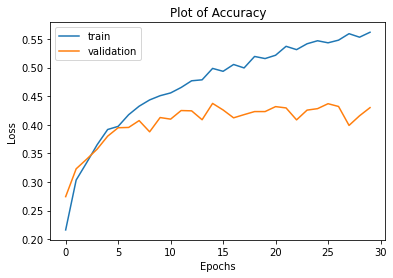

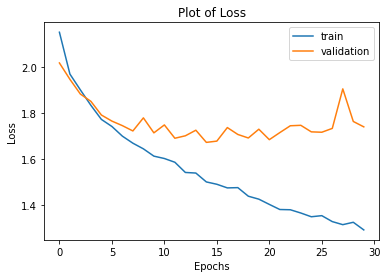

31/31 [==============================] - 0s 2ms/step - loss: 1.7392 - accuracy: 0.4301
Testing loss 	 1.7392451763153076
Testing accuracy  0.4300636947154999


In [75]:
print('Final training loss \t', h2.history['loss'][-1])
print('Final training accuracy ', h2.history['accuracy'][-1])

# plot the training  accuracy  

plt.plot(h2.history['accuracy'], label='train')
plt.plot(h2.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Accuracy')
plt.legend()
plt.show()

# plot the traininig loss 

plt.plot(h2.history['loss'], label='train')
plt.plot(h2.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss')
plt.legend()
plt.show()

# testing the model

testLoss, testAccuracy = model.evaluate(ds_test.take(1000), batch_size=32)


print('Testing loss \t', testLoss)
print('Testing accuracy ', testAccuracy)

y_pred = model.predict(ds_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in ds_test], axis=0)

In [76]:
confusion_matrix(predicted_categories, true_categories)

array([[232,  19,   6,  39,  15,  30,  16,  26,  18,   3],
       [ 19, 103,  31,  34,   7,  30,  16,  26,  21,   6],
       [  2,  19, 153,  27,   7,  14,  25,  22,  15,   8],
       [ 18,  50,  18,  94,  11,  43,  10,  40,  15,  15],
       [  9,  20,  16,  19, 208,  41,  28,  44,  23,  32],
       [ 19,  30,  25,  51,  45, 139,  21,  43,  22,  16],
       [ 40,  38,  47,  50,  37,  35, 226,  60,  34,  28],
       [ 17,  39,  23,  34,  22,  35,  17,  90,  22,  13],
       [ 23,  57,  23,  20,  27,  21,  21,  40, 189,  15],
       [  8,  20,  15,  18,  30,   6,   9,  28,  40, 254]])

In [77]:
cl = ds_info.features['label']
print(classification_report(true_categories, predicted_categories, target_names=cl.names))

              precision    recall  f1-score   support

   n01440764       0.57      0.60      0.59       387
   n02102040       0.35      0.26      0.30       395
   n02979186       0.52      0.43      0.47       357
   n03000684       0.30      0.24      0.27       386
   n03028079       0.47      0.51      0.49       409
   n03394916       0.34      0.35      0.35       394
   n03417042       0.38      0.58      0.46       389
   n03425413       0.29      0.21      0.25       419
   n03445777       0.43      0.47      0.45       399
   n03888257       0.59      0.65      0.62       390

    accuracy                           0.43      3925
   macro avg       0.43      0.43      0.42      3925
weighted avg       0.42      0.43      0.42      3925



In [78]:
print("miss classified label index, predicted_label, actual_label")
for i in range(20):
  if(np.argmax(y_pred[i]) != y_test_flat[i]):
    print(i, np.argmax(y_pred[i]), y_test_flat[i])

miss classified label index, predicted_label, actual_label
3 5 3
4 4 7
6 6 3
7 8 7
10 7 1
11 7 3
12 2 7
14 8 9
18 3 5
19 1 0


## **Summary**

### **Observations**

**Model1** - *Model with Dropout + Regularization*

**Model2** - *Model with different Dropout position and differrent value*

**Model3** - *Model without regularization*

### **1.   Model Accuracy and Loss**

>*   When we compare 3 models **Model3** as best training accuracy and low training loss. But **Model2** has bad training accuracy and high training loss. **Model1** has little bit better accuracy than **Model2** and lesser accuracy than **Model3**.

* Differrence in accuracy is because of Dropout and regualarization.
    
  * **How the Dropout effecting the result?**
    - Def:  Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.
    -  As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations. 
    - You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network. The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

 * **How the regularization effecting the result?**
   * Regularization refers to a set of different techniques that lower the complexity of a neural network model during training, and thus prevent the overfitting.
   * Performing L2 regularization encourages the weight values towards zero (but not exactly zero). Intuitively speaking smaller weights reduce the impact of the hidden neurons. In that case, those hidden neurons become neglectable and the overall complexity of the neural network gets reduced. Then the less complex models typically avoid modeling noise in the data, and therefore, there is no overfitting.













